# Visualize the quantize embedding

In [1]:
import torch
from config import *
from vqvae import VQVAE
import matplotlib.pyplot as plt
from einops import rearrange
from torchvision import transforms
from torch import Tensor

/opt/data/private/linkdom/miniconda3/envs/GPT/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VQVAE(**model_kwargs).to(device)
model_path = "ckpt/unmask_vqvae_imagenet_10epo.pth"
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [3]:
model.eval()

VQVAE(
  (encoder): Encoder(
    (blocks): Sequential(
      (0): SubSampleBlock(
        (blocks): Sequential(
          (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (3): ReLU(inplace=True)
          (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (1): ResBlock(
        (conv): Sequential(
          (0): ReLU(inplace=True)
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (2): ResBlock(
        (conv): Sequential(
          (0): ReLU(inplace=True)
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )

In [4]:
image_size = 224
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
])
def show_images(images:Tensor):
    return transforms.ToPILImage()(images)

## test pretrained model on cifar10

In [5]:
from torchvision.datasets import CIFAR10

cifar10 = CIFAR10(root="/opt/data/private/linkdom/data/", download=False, train=False, transform=transform)

truck


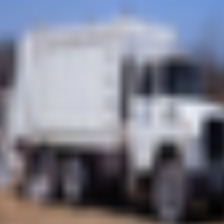

In [6]:
idx = torch.randint(0, len(cifar10), (1,)).item()
itoc = cifar10.classes
image, label = cifar10[idx]
print(itoc[label])
show_images(image)

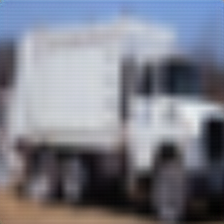

In [7]:
recon_image, quantize_idx = model(image.unsqueeze(0).to(device))
show_images(recon_image.squeeze(0))

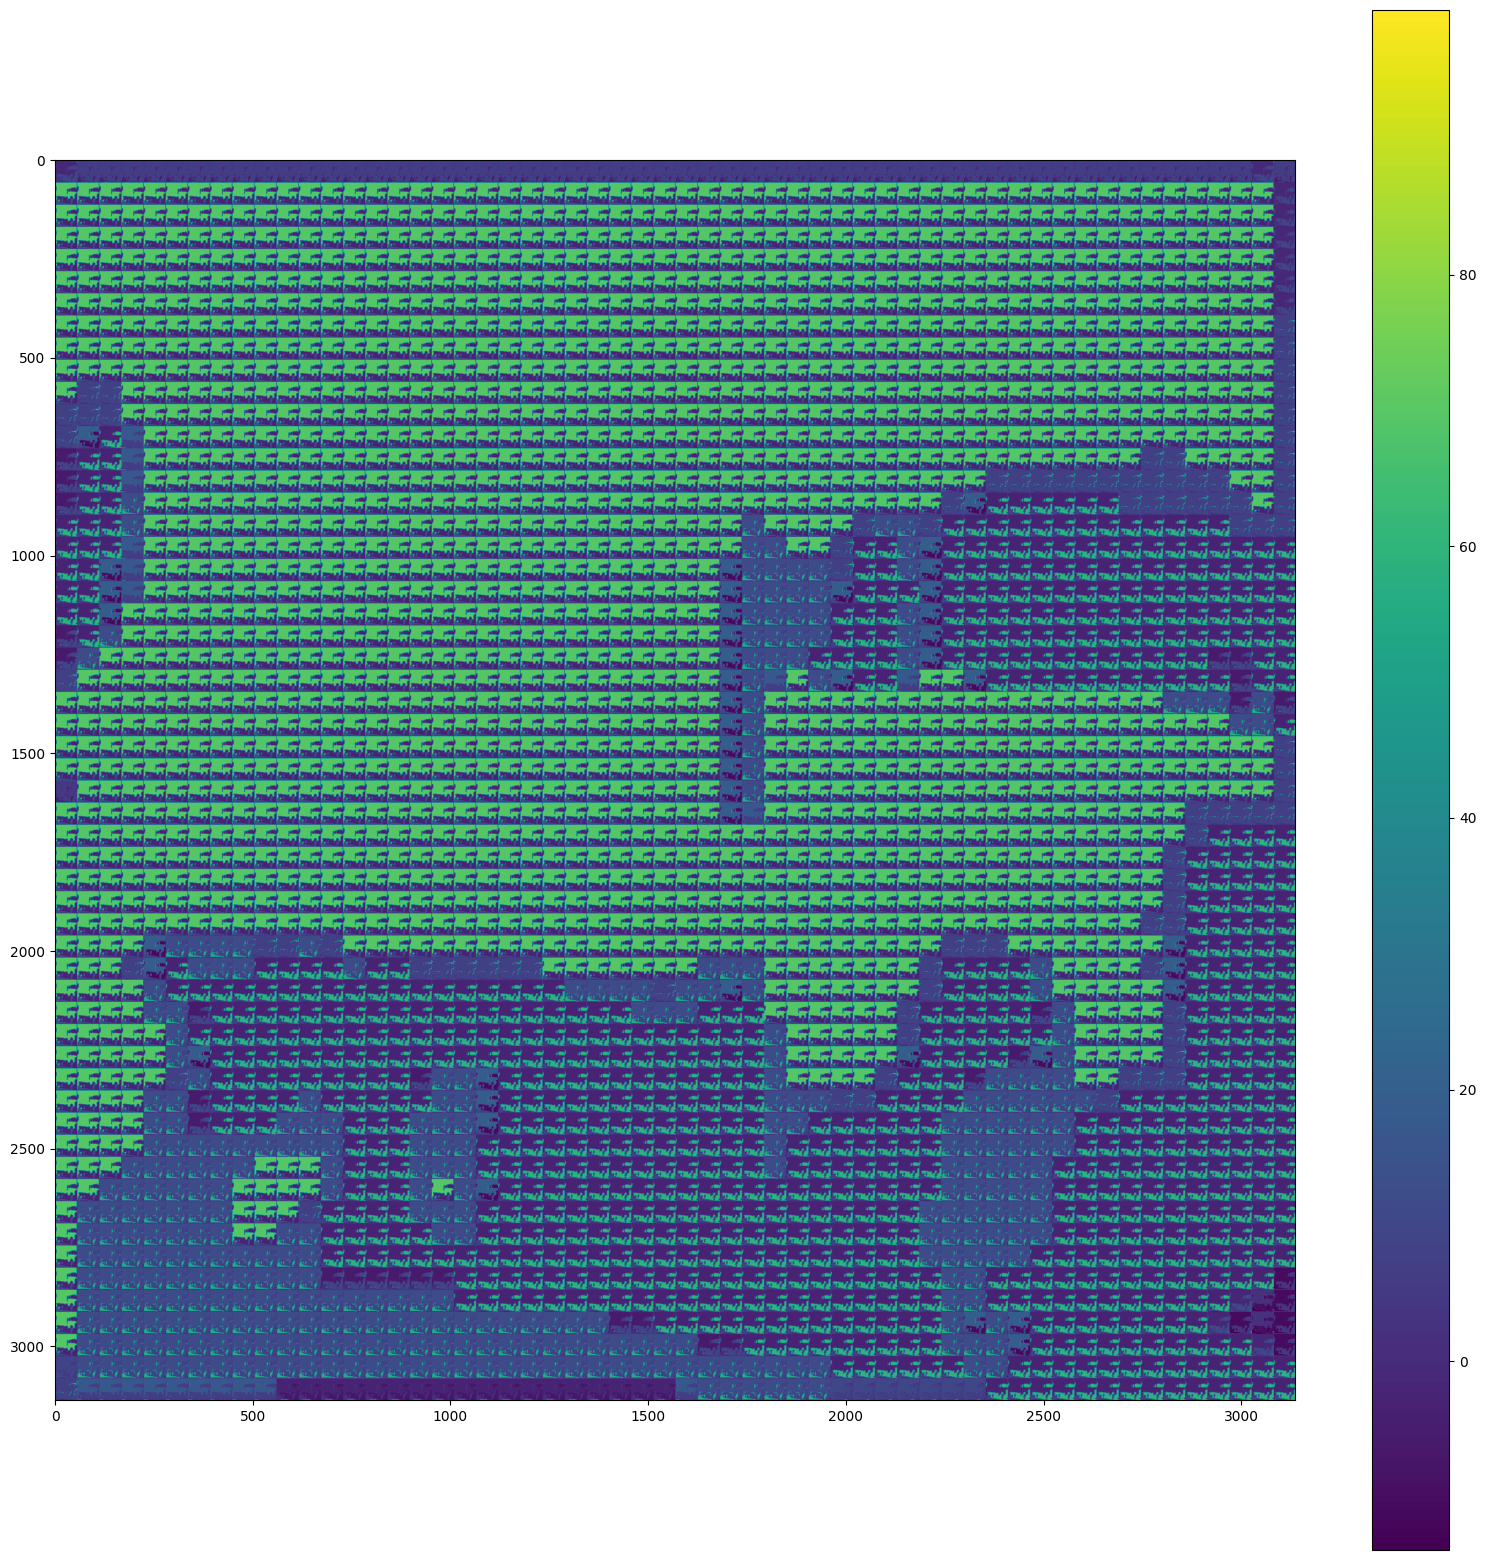

In [8]:
image_embd = model.quantize.embd(quantize_idx.squeeze(0))
image_attention = (image_embd @ image_embd.T)
img_size = 56
image_attention = rearrange(
    image_attention, 
    '(h1 w1) (h2 w2) -> (h1 h2) (w1 w2)', 
    h1=img_size, w1=img_size, h2=img_size, w2=img_size
)

plt.figure(figsize=(20, 20))
plt.imshow(image_attention.cpu().detach().numpy(), cmap="viridis")
plt.colorbar()
plt.show()

## test pretrained model on your own picture

<div align="center"><img src="flower.png" width=200></div>


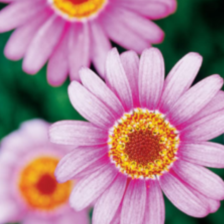

In [9]:
from PIL import Image

def load_image(path):
    img = Image.open(path).convert("RGB")
    img = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
    ])(img)
    return img

image = load_image("flower.png")
show_images(image)

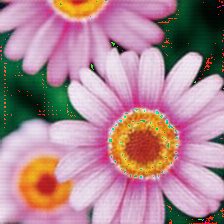

In [10]:
recon_image, quantize_idx = model(image.unsqueeze(0).to(device))
show_images(recon_image.squeeze(0))

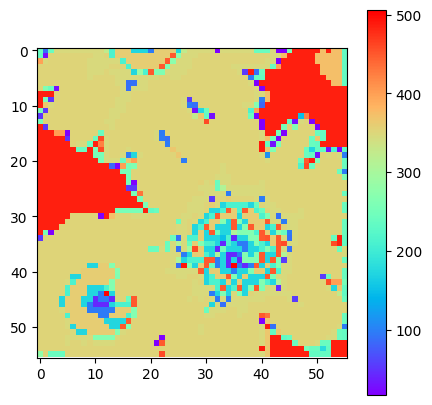

In [60]:
quantize_idx_label = rearrange(
    quantize_idx.squeeze(0),
    '(h w) -> h w',
    h=img_size, w=img_size
)
import matplotlib.cm as cm
import numpy as np
colors = cm.rainbow(np.linspace(0, 1, 512))

plt.figure(figsize=(5, 5))
plt.imshow(quantize_idx_label.cpu().detach().numpy(), cmap=cm.colors.ListedColormap(colors))
plt.colorbar()
plt.show()

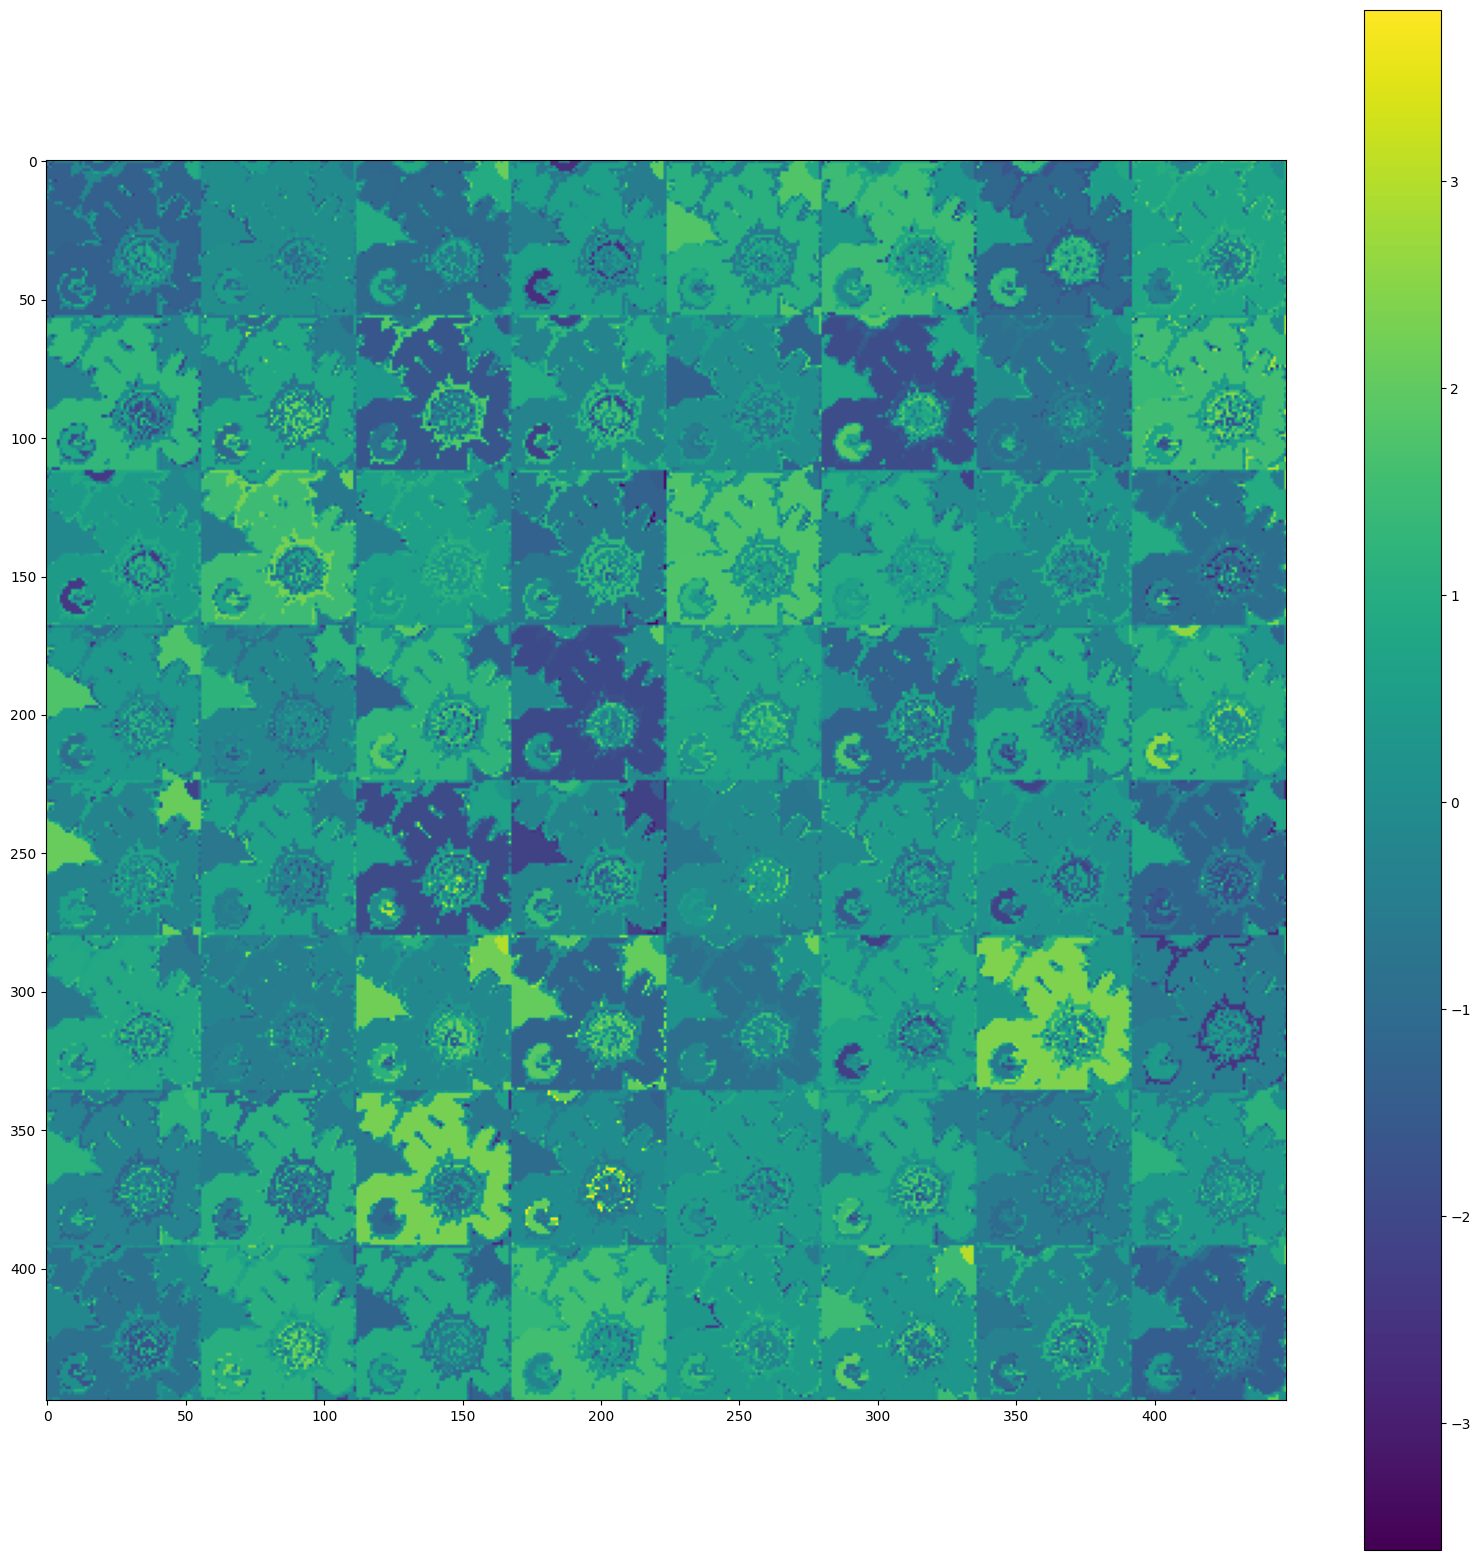

In [11]:
image_embd = model.quantize.embd(quantize_idx.squeeze(0))
image_embd = rearrange(
    image_embd, 
    '(h1 w1) (nh nw) -> (nh h1) (nw w1)', 
    h1=img_size, w1=img_size, nh = 8, nw = 8
)
plt.figure(figsize=(20, 20))
plt.imshow(image_embd.cpu().detach().numpy(), cmap="viridis")
plt.colorbar()
plt.show()

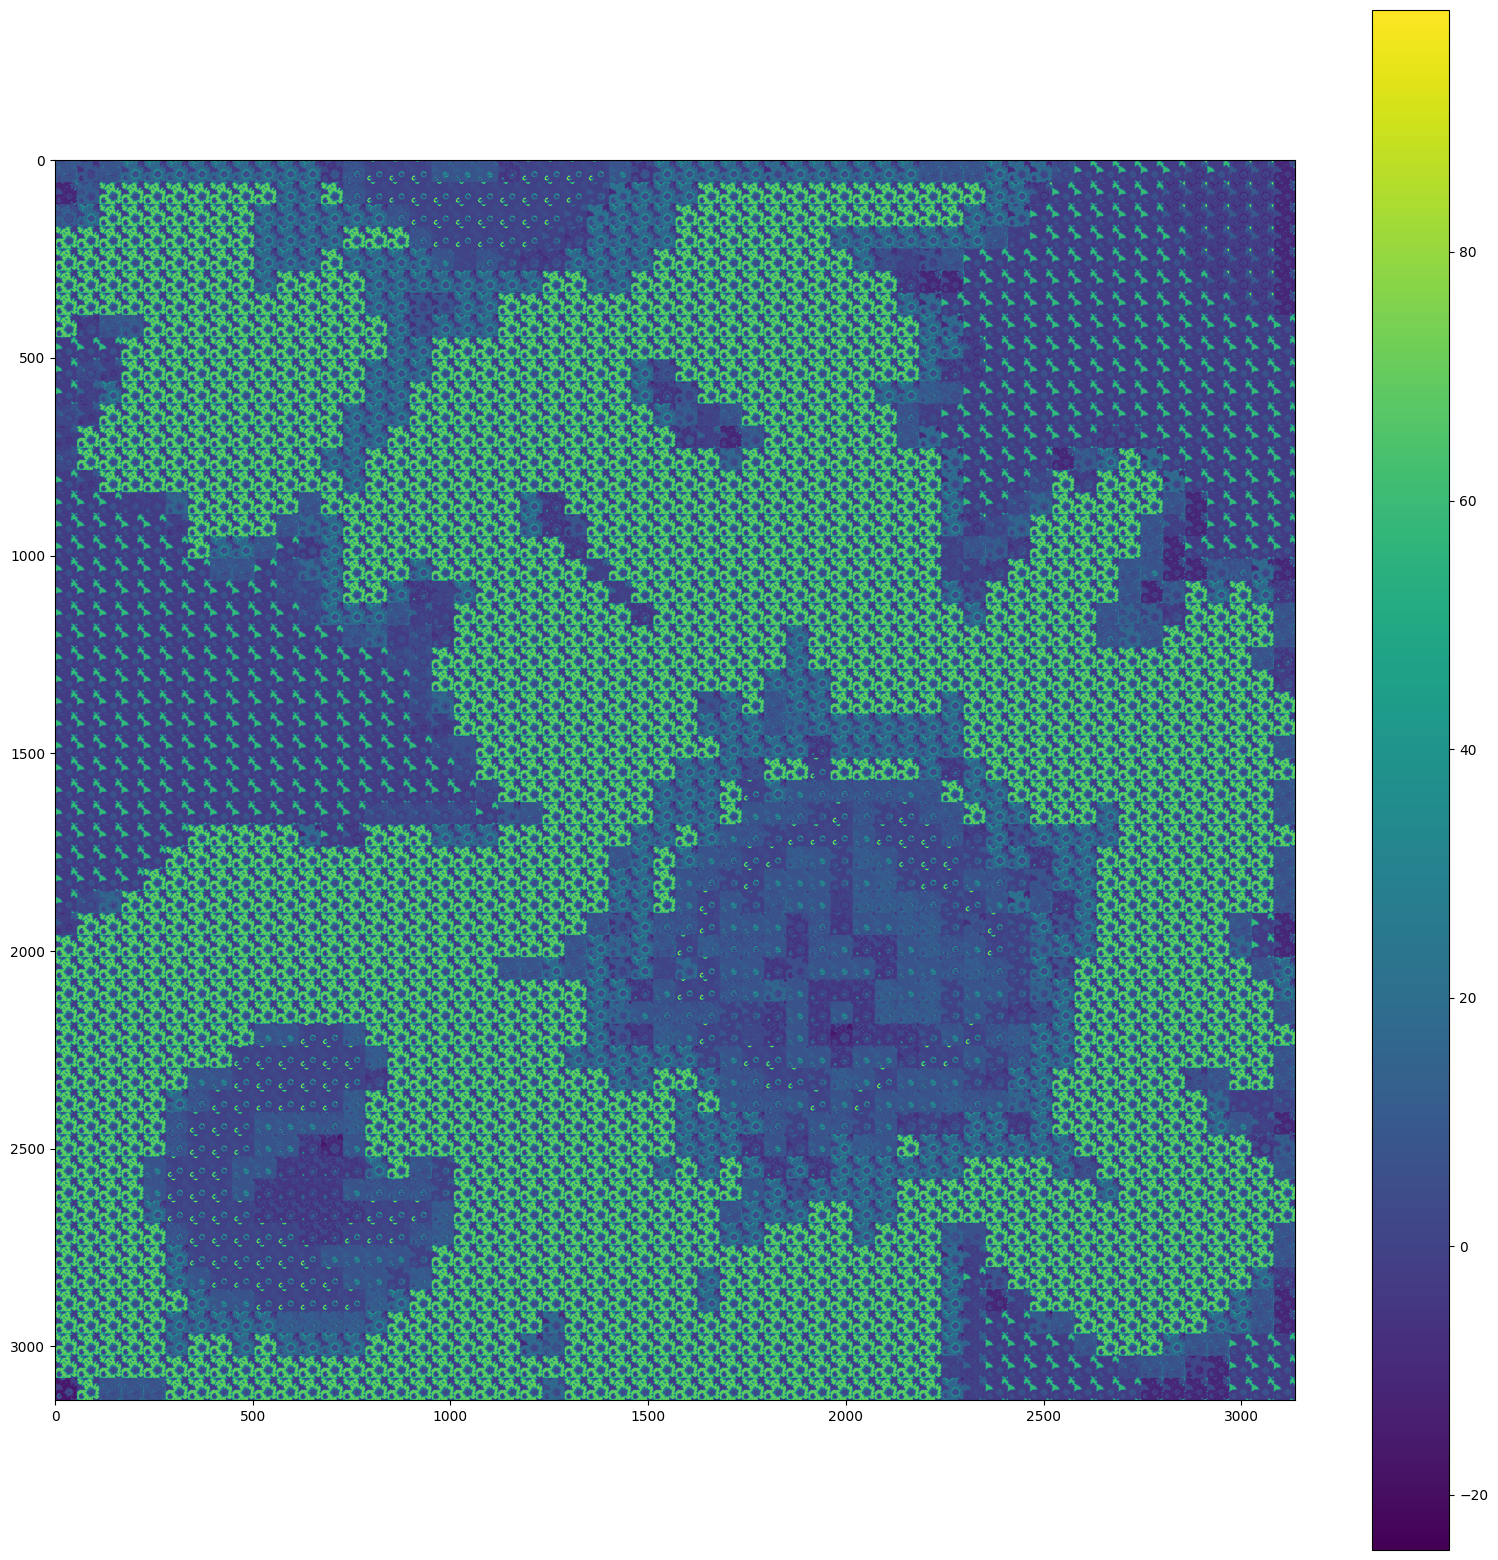

In [13]:
image_embd = model.quantize.embd(quantize_idx.squeeze(0))
image_attention = (image_embd @ image_embd.T)
img_size = 56
image_attention = rearrange(
    image_attention, 
    '(h1 w1) (h2 w2) -> (h1 h2) (w1 w2)', 
    h1=img_size, w1=img_size, h2=img_size, w2=img_size
)

plt.figure(figsize=(20, 20))
plt.imshow(image_attention.cpu().detach().numpy(), cmap="viridis")
plt.colorbar()
plt.show()

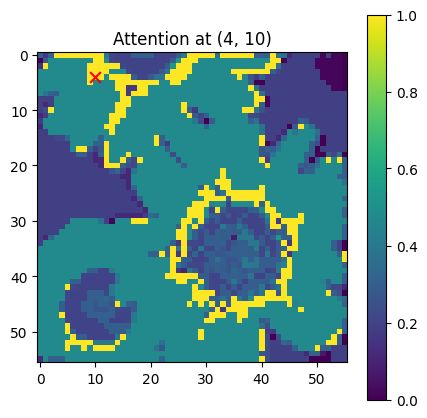

In [54]:
irow = torch.randint(0, 56, (1,)).item()
jcol = torch.randint(0, 56, (1,)).item()
y1, y2 = irow*img_size, (irow+1)*img_size
x1, x2 = jcol*img_size, (jcol+1)*img_size
partial_attention = image_attention[y1:y2, x1:x2]

plt.figure(figsize=(5, 5))
plt.imshow(partial_attention.cpu().detach().numpy(), cmap="viridis")
plt.scatter(jcol, irow, color="red", marker="x", s=60)
plt.colorbar()
plt.title(f"Attention at ({irow}, {jcol})")
plt.show()